<a href="https://colab.research.google.com/github/Deepakkarki24/Coronavirus-Tweet-Sentiment-Analysis/blob/main/Deepak_Karki_Coronavirus_Tweet_Sentiment_Analysis_Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b><u> Project Title : Sentiment Analysis : Predicting sentiment of COVID-19 tweets</u></b>

## <b> Problem Description </b>

### This challenge asks you to build a classification model to predict the sentiment of COVID-19 tweets.The tweets have been pulled from Twitter and manual tagging has been done then.

### The names and usernames have been given codes to avoid any privacy concerns.

### You are given the following information:
1. Location
2. Tweet At
3. Original Tweet
4. Label

### **Importing libraries**

In [1]:
#Importing Libraries 
import pandas as pd
import numpy as np
#Libraries for visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import plotly.graph_objects as go
#Libraries to suppress warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Sklearn Libraries
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import PassiveAggressiveClassifier

In [3]:
# NLP Libraries
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

## **Importing Dataset**

In [4]:
#Mounting drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
#Loading the dataset
df_tweet = pd.read_csv('/content/drive/MyDrive/ALMABETTER/CAPSTONE PROJECTS/CAPSTONE PROJECT 3 - Coronavirus Tweet Sentiment Analysis/Csv file/Coronavirus Tweets.csv',encoding="ISO-8859-1")

In [6]:
#Creating a copy of the dataset
df = df_tweet.copy()

## **Exploratory Data Analysis**

In [7]:
#First look
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [8]:
#Checking Basic Information About Dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32567 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.9+ MB


In [9]:
#Checking the shape of the dataset
print("The dataset contains :",df.shape[0],"rows")
print("The dataset contains :",df.shape[1],"columns")

The dataset contains : 41157 rows
The dataset contains : 6 columns


In [10]:
#Checking for duplicates
print("Number of duplicates present in the dataset :",len(df[df.duplicated()]))

Number of duplicates present in the dataset : 0


In [11]:
#Getting count of the null values 
df.isnull().sum()

UserName            0
ScreenName          0
Location         8590
TweetAt             0
OriginalTweet       0
Sentiment           0
dtype: int64

We can observe that only the column 'Location' contains null values. But we are not considering that column for sentiment analysis. Hence there is no need for null value treatment.

## **Creating word cloud to show different variabls in the dataset.**

In [12]:
#Importing Other libraries 
import re
import sys
import requests
from PIL import Image
import requests as r
from wordcloud import WordCloud
from collections import Counter
from collections import defaultdict

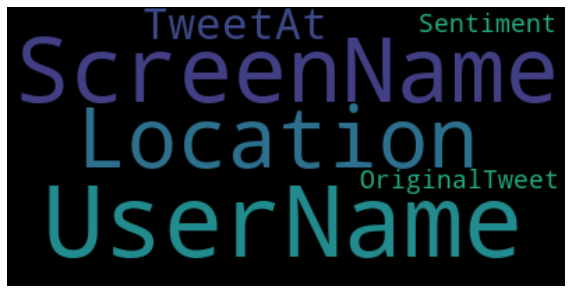

In [13]:
#Storing the column names to make a word cloud
plt.rcParams['figure.figsize']=10,10
text1 = " ".join(title for title in df.columns)
# Creating word_cloud with text as argument in .generate() method
word_cloud1 = WordCloud(collocations = False, background_color = 'black').generate(text1)
# Display the generated Word Cloud
plt.imshow(word_cloud1, interpolation='bilinear')
plt.axis("off")
plt.show()

In [14]:
#Unique values
df.nunique()

UserName         41157
ScreenName       41157
Location         12220
TweetAt             30
OriginalTweet    41157
Sentiment            5
dtype: int64

### It is clear that ScreenName and UserName are unique for each observation in the given dataset. Therefore we will remove them.

In [15]:
#Drop UserName and ScreenName
df.drop(["UserName","ScreenName"],axis=1,inplace=True)

### **Target variable analysis**

### Since our target variable is Sentiment, So analyzing our target variable, Sentiment.

In [16]:
#Getting Sentiment Count from the dataset
df.groupby('Sentiment').count()

,Location,TweetAt,OriginalTweet
Sentiment,,,
Extremely Negative,4249,5481,5481
Extremely Positive,5273,6624,6624
Negative,7763,9917,9917
Neutral,6172,7713,7713
Positive,9110,11422,11422


In [17]:
df.Sentiment.unique()

array(['Neutral', 'Positive', 'Extremely Negative', 'Negative',
       'Extremely Positive'], dtype=object)

### We have 5 subcategories for Sentiment, and they are 'Neutral', 'Positive', 'Extremely Negative', 'Negative' and 'Extremely Positive'.

Text(0, 0.5, 'Number of tweets')

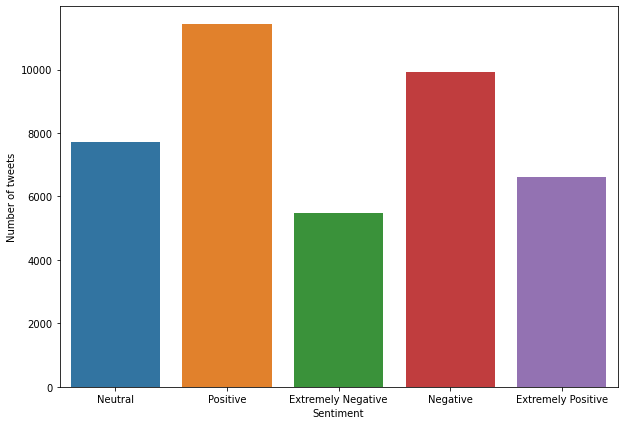

In [18]:
#Plotting the graph for the total number of tweets for each subcategory in the target variable (SENTIMENT)
plt.rcParams["figure.figsize"]=10,7
sns.countplot(x="Sentiment", data=df)
plt.ylabel("Number of tweets")

### **Since we have 5 subcategories here, So we will convert this 5-class classification problem into a 3-class classification problem by merging Extremely Positive tweets with positive tweets and Extremely Negative tweets with negative tweets.**

In [19]:
def Sentiment_Grouping(sentiment):

  '''This function will combiner Extremely Positive tweets with Positive Category
     and Extremely Negative tweets with Negative Category'''

  if sentiment == "Extremely Positive":
    return "Positive"
  elif sentiment == "Extremely Negative":
    return "Negative"
  else:
    return sentiment

In [20]:
#Apply the Sentiment_Grouping function on the Sentiment column
df["Sentiment"] = df["Sentiment"].apply(Sentiment_Grouping)
df['Sentiment'].unique()

array(['Neutral', 'Positive', 'Negative'], dtype=object)

Now sentiment subcategories are :

*   POSITIVE
*   NEGATIVE
*   NEUTRAL



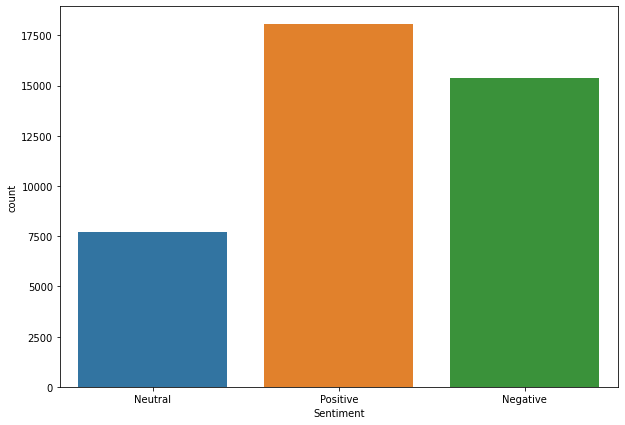

In [21]:
1#Plotting the graph for the total number of tweets for the new 3 subcategories of the target variable
plt.rcParams["figure.figsize"]=10,7
sns.countplot(x="Sentiment", data=df)

### **Different Location Analysis**

In [22]:
#Getting total number of tweets tweeted from all the locations
location = df['Location'].value_counts().reset_index()
location.rename(columns={'index':"location","Location":"count"},inplace=True)
location


,location,count
0,London,540
1,United States,528
2,"London, England",520
3,"New York, NY",395
4,"Washington, DC",373
...,...,...
12215,Staffordshire Moorlands,1
12216,Kithchener ON,1
12217,"Tulsa, Ok",1
12218,"Watford, South Oxhey, Bushey",1


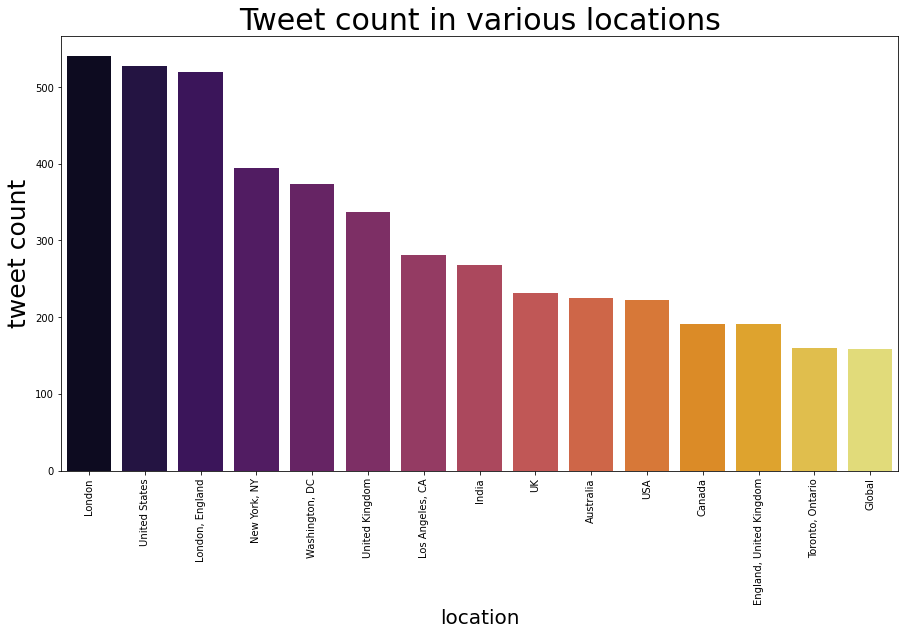

In [23]:
#Plotting number of tweets v/s location
plt.rcParams["figure.figsize"]=(15,8)
sns.barplot(location["location"][0:15], x = 'location', y =location["count"][0:15], palette ='inferno').tick_params(axis='x', rotation=90)
plt.title('Tweet count in various locations', fontsize = 30)
plt.xlabel('location', fontsize = 20)
plt.ylabel('tweet count', fontsize = 25)
plt.show()

### **Top 10 Locations**

In [24]:
location_top10 = df['Location'].value_counts().sort_values(ascending=False)[:10]
location_top10

London             540
United States      528
London, England    520
New York, NY       395
Washington, DC     373
United Kingdom     337
Los Angeles, CA    281
India              268
UK                 232
Australia          225
Name: Location, dtype: int64

### **Count plot of top 10 locations**

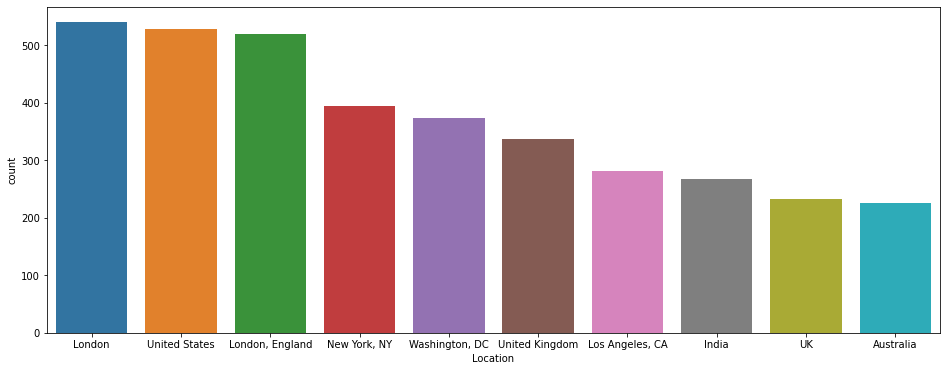

In [25]:
plt.figure(figsize=(16,6))
sns.countplot(data=df[df['Location'].isin(location_top10.index)], x='Location',order=location_top10.index)

In [26]:
#Converting the TweetAt column to a datetime object
df["TweetAt"] = pd.to_datetime(df["TweetAt"])

In [27]:
#Obtaining the time period of the dataset 
print("Our dataset contains tweets from {}th {} {} to {}th {} {}".format(df["TweetAt"].min().day, df["TweetAt"].min().month_name(), df["TweetAt"].min().year,
df["TweetAt"].max().day, df["TweetAt"].max().month_name(), df["TweetAt"].max().year))

Our dataset contains tweets from 4th January 2020 to 4th December 2020


### Creating Day, Month & Week Day name from "TweetAt" column

In [28]:
df['day'] = pd.DatetimeIndex(df['TweetAt']).day
df['month'] = pd.DatetimeIndex(df['TweetAt']).month
#Creating a column containing name of the weekday
df["week day"] = pd.DatetimeIndex(df['TweetAt']).day_name()

In [29]:
df.head()

,Location,TweetAt,OriginalTweet,Sentiment,day,month,week day
0,London,2020-03-16,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,16,3,Monday
1,UK,2020-03-16,advice Talk to your neighbours family to excha...,Positive,16,3,Monday
2,Vagabonds,2020-03-16,Coronavirus Australia: Woolworths to give elde...,Positive,16,3,Monday
3,NaN,2020-03-16,My food stock is not the only one which is emp...,Positive,16,3,Monday
4,NaN,2020-03-16,"Me, ready to go at supermarket during the #COV...",Negative,16,3,Monday


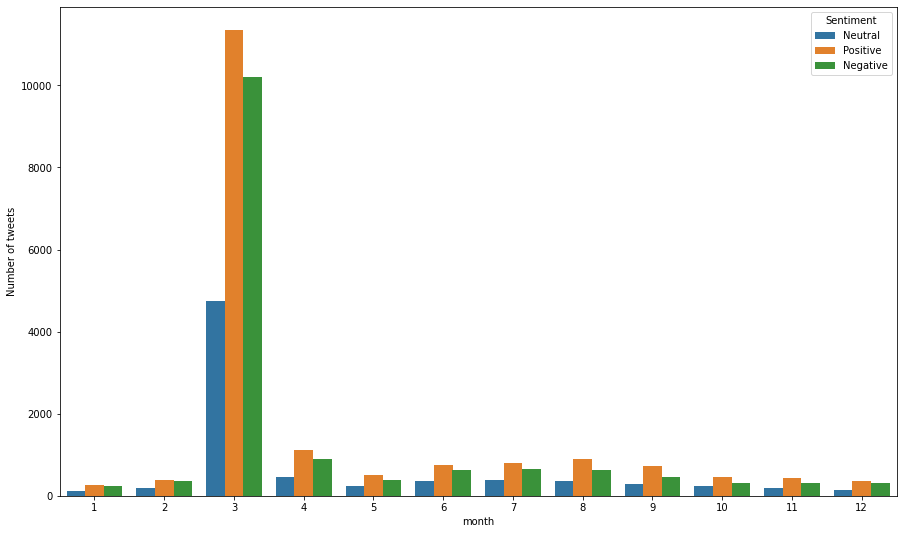

In [30]:
#Plotting total number of tweets for each sentiment over the months
plt.rcParams["figure.figsize"]=(15,9)
xyz = sns.countplot(x="month", hue="Sentiment", data=df)
plt.ylabel("Number of tweets")
plt.show()

So from the above countplot it is clear the most number of tweets were created in the month of March followed by april.

### **Since most tweets are tweeted in the month of march, So let's analyze the tweet count on a daily basis in the month of March.**

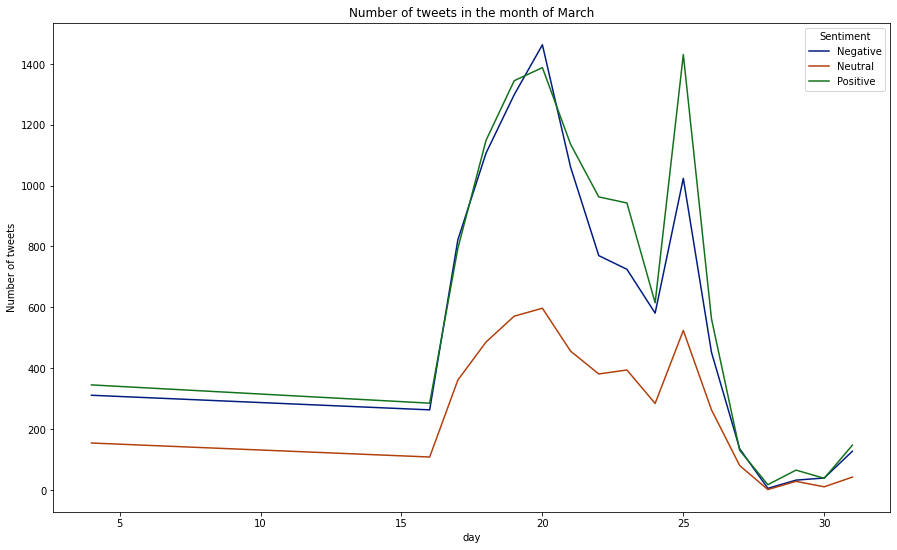

In [31]:
 #Creating a subset of our dataframe that will only contains tweets from the month of march
d_analysis = df[df["month"] == 3].copy()
#Grouping our dataset
daySentiment_groupby = d_analysis.groupby(["day" , "Sentiment"]).agg({ "OriginalTweet" : "count"}).reset_index()
sns.lineplot(x = "day" , y ="OriginalTweet" , hue="Sentiment" ,  data = daySentiment_groupby , palette = 'dark' )
plt.title("Number of tweets in the month of March")
plt.ylabel("Number of tweets")
plt.show()

### Now let's check out on which day people tweet the most.

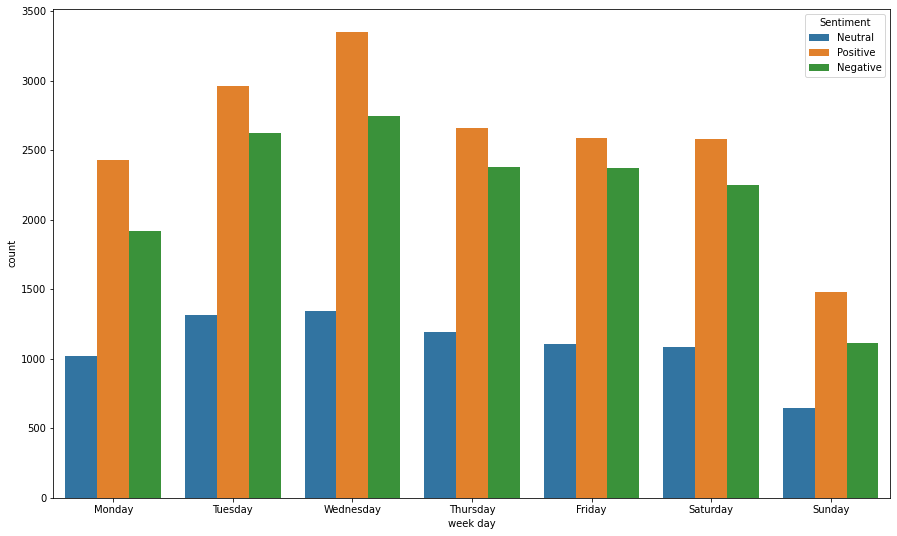

In [32]:
#Checking which day people are creating more tweets
xyz = sns.countplot(x="week day", hue="Sentiment", data=df)

We expected it to be the holiday (sunday) that people tweet the most. But on Wednesday it was found that people were tweeting the most followed by tuesday & thursday and also least tweets are tweeted on sunday. This may be the result of lockdown.

## **Tweet Length Analysis**

In [33]:
#Creating a new column 'length' by calculating the length of tweets
df['length']=df['OriginalTweet'].apply(len)
df.head()

,Location,TweetAt,OriginalTweet,Sentiment,day,month,week day,length
0,London,2020-03-16,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,16,3,Monday,111
1,UK,2020-03-16,advice Talk to your neighbours family to excha...,Positive,16,3,Monday,237
2,Vagabonds,2020-03-16,Coronavirus Australia: Woolworths to give elde...,Positive,16,3,Monday,131
3,NaN,2020-03-16,My food stock is not the only one which is emp...,Positive,16,3,Monday,306
4,NaN,2020-03-16,"Me, ready to go at supermarket during the #COV...",Negative,16,3,Monday,310


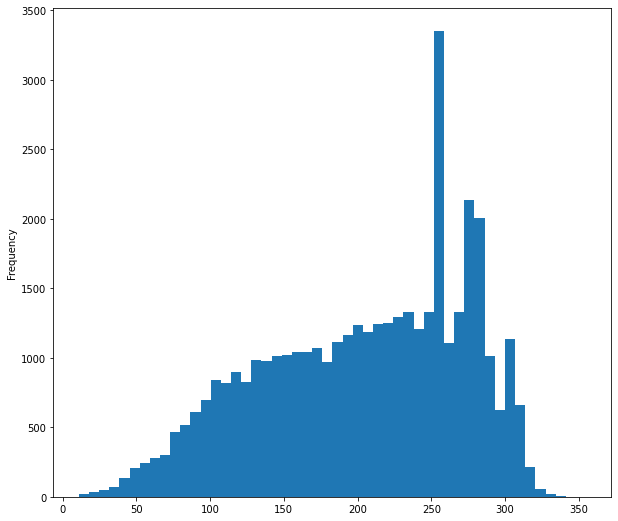

In [34]:
#Checking distribution of length of tweets
plt.rcParams["figure.figsize"]=(10,9)
df['length'].plot(bins=50,kind='hist')

In [35]:
def show_dist(df, col):

  '''Function is to show distribution of any particular column for each of the different sentiment'''

  bins = np.arange(df[col].min(), df[col].max() + 1)
  g = sns.FacetGrid(df, col='Sentiment', height=5, hue='Sentiment', palette="bright")
  g = g.map(sns.histplot, col, kde=False, bins=bins)

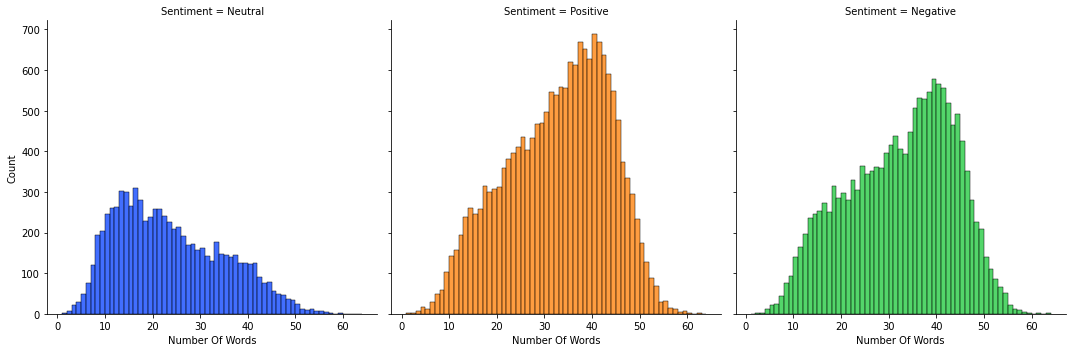

In [36]:
#Creating a new column named "Number Of Words" to store the number of words in each tweet
df["Number Of Words"] = df["OriginalTweet"].str.split().apply(len)
show_dist(df , 'Number Of Words')

The number of words present in tweets of neutral sentiment is far less when compared to tweets with a positive or negative sentiment . Most of the positive and negative sentiment tweets contain almost 40 words on average.

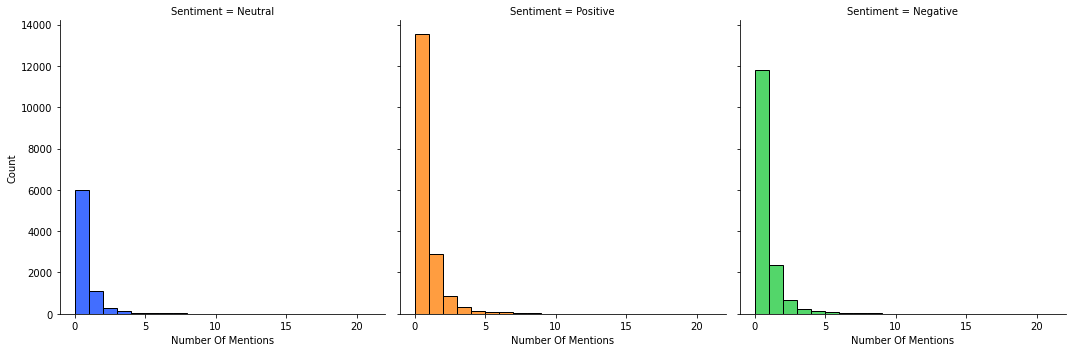

In [37]:
#Creating a new column named "Number Of Mentions" to store the number of mentions in each tweet
df["Number Of Mentions"] = df["OriginalTweet"].apply(lambda tweet : len(re.findall(r'@[^\s]+', tweet)))
show_dist(df, "Number Of Mentions")

*Most of the tweets contain no mention and there is no particular relationship between number of mentions and regard the sentiment.*

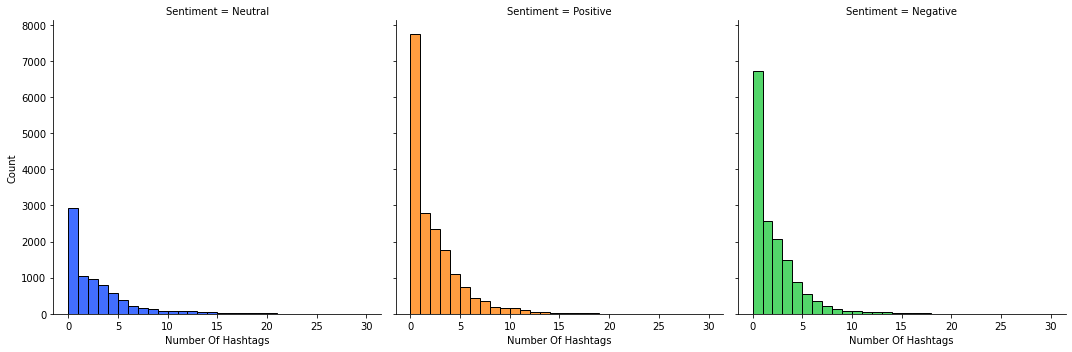

In [38]:
#Creating a new columns named "Number Of Hashtags" to store the number of hastags in each tweet
df["Number Of Hashtags"] = df["OriginalTweet"].apply(lambda tweet : len(re.findall(r'#[^\s]+', tweet)))
show_dist(df, "Number Of Hashtags")

Most tweets do not have a hashtag. Again, the number of hashtags has nothing to do with the sentiment.